In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, nquad, simps
from scipy.special import ellipe, ellipk
from scipy.interpolate import lagrange, InterpolatedUnivariateSpline
from scipy.signal import savgol_filter

## Notes

__From rotmod.c:__ <br>
For the  sampling radii you should use an increment of about 0.2 times the disk scale length, and the maximum sampling radius should at least be larger than the radius of the last measured point on your observed rotation curve. <br>
If the user wants to enter a measured density profile, and the central density is not given (density at R=0), the program will use linear extrapolation to obtain the central density.

## User input

In [2]:
user = True  # use imported data

# Gas:
# Conversion to linear scale was made in the notebook: grav_project/NGC_5005/Gas_from_mass_surface_density.ipynb
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
units = 'KPC,MSUN/PC**2'
radii = np.arange(0.1,11.18,0.1)               # Sampling radii

# Disk:
# See for more: grav_project/NGC_5005/Disk_from_surface_brightness_profile.ipynb
#raddens = "../data/NGC5005-disk_arcsec.txt"    # Disk surface brightness with 4 colums, units: ARCSEC, MAG/ARCSEC^2
#units = 'ARCSEC,MAG/ARCSEC**2'
#radii = np.arange(0.001,35,0.01)

zlaw = 2                            # Case 2: sech-squared density law
mode = zlaw                         # Density distribution mode

# Parameters
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 0.000001
z0 = 0.93
distance = 16.5                    # Distance in MPC

# we only need dens0 and h if user is FALSE (i.e. when density is calculated), otherwise we don't need it
h = 2                              # GUESS: radial scale-length (KPC)
#dens0 = 10**2.4                    # GUESS: central surface density (MSUN/PC^2): from Fig 8. Paper 13
dens0 = 4e2                        # GUESS: central surface density (MSUN/PC^2)

## Density distribution

In [3]:
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0
#####################################

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0    # In the GIPSY rotmod.c, this is multiplied by z0 but in Caserano Eq 2 there isn't any z0
    #r = r * r
    r = 1.0 / r
    return r           # calling this r is kind of misleading but Rotmod is calling it r
                       # returns: density as a function of z (I think)

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case3(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

## Density profile

In [4]:
def DensityProfile(user=user,raddens=raddens,units=units,mode=mode,dens0=dens0,h=h):
    
    ##################################
    # Case 1: Import density profile #
    ##################################
    
    if user == True:
        if units == 'KPC,MSUN/PC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

        if units == 'ARCSEC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # ARCSEC to KPC
            xdinp = 4.8481E-3 * distance * xdinp

            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp
            
        if units == 'KPC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp
            
        LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
        LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
        ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
        rcut = xdinp[ndinp-1]               # takes second to last radius value
        delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value
    
    
    #####################################
    # Case 2: Calculate density profile #
    #####################################
    
    if user == False:
    
        # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
        dens0 = dens0           # central density of exponential DISK
        # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
        #dens0 = 10**(-0.4 * dens0)       
        #dens0 = (4.8481E-3 * distance)**(-2) * dens0
        #dens0 = dens0 * 1.0e6        
        #print("dens0 = {:.4}".format(dens0))

        h = h                   # radial scale length
        z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                                  # note: The integration in Z is the most time consuming part
                                  # of the calculation. For example it takes about 0.2 seconds
                                  # to calculate a point on the rotation curve for a disk with zero
                                  # thickness, and about 2 seconds for a disk with non-zero thickness.
        rcut = 4*h              # cutoff radius
        delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                                  # to have a non-zero softening in case of a truncated disk, 
                                  # because then the sharp features in the calculated rotation 
                                  # curve will be smoothed out. A softening parameter of about 
                                  # 0.2 scale lengths would be sufficient.

        # Now calculate the surface densities
        LEN1 = 1000
        LEN2 = 1000
        xdinp = np.zeros(LEN2-1)    # radii surface density
        ydinp = np.zeros(LEN2-1)    # surface densities
        rdinp = rcut + delta      # max radius, where galaxy ends
        ndinp = LEN2 - 1          # number of surface densities
        xstep = rdinp / (ndinp - 1)        # step in radius

        i = 0                              # counter 
        while i < ndinp:
            # Casertano's piecewise function (Eq.3)
            xdinp[i] = x = xstep * i
            if x >= rcut and delta > 0.0:
                y = dens0 * np.exp(-rcut/h)*(rcut+delta-x)/delta
            elif x >= rdinp:
                y = 0.0                    # end of disk
            else:
                y = dens0 * np.exp(-x/h)
            ydinp[i] = y
            i += 1
    return xdinp, ydinp, ndinp, rcut, delta, LEN1, LEN2

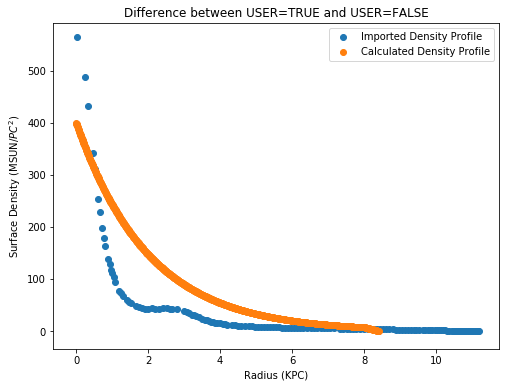

In [5]:
# Plot 
plt.figure(figsize=(8,6))
xdinp_imported = DensityProfile(user=True)[0]
ydinp_imported = DensityProfile(user=True)[1]
plt.scatter(xdinp_imported,ydinp_imported, label="Imported Density Profile")

xdinp_calculated = DensityProfile(user=False)[0]
ydinp_calculated = DensityProfile(user=False)[1]
plt.scatter(xdinp_calculated,ydinp_calculated, label="Calculated Density Profile")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.title("Difference between USER=TRUE and USER=FALSE")
plt.legend()
plt.show()

## Define some values

In [6]:
# Radius
xdinp = DensityProfile()[0]
# Density
ydinp = DensityProfile()[1]

# Cutoff radius
rcut = DensityProfile()[3]
# Cutoff length
delta = DensityProfile()[4]

# Set the first value of sampling radius equal to the first value of measured radius
radii[0] = xdinp[0]

In [7]:
print(xdinp[0])
print(radii)

0.0172
[ 0.0172  0.2     0.3     0.4     0.5     0.6     0.7     0.8     0.9
  1.      1.1     1.2     1.3     1.4     1.5     1.6     1.7     1.8
  1.9     2.      2.1     2.2     2.3     2.4     2.5     2.6     2.7
  2.8     2.9     3.      3.1     3.2     3.3     3.4     3.5     3.6
  3.7     3.8     3.9     4.      4.1     4.2     4.3     4.4     4.5
  4.6     4.7     4.8     4.9     5.      5.1     5.2     5.3     5.4
  5.5     5.6     5.7     5.8     5.9     6.      6.1     6.2     6.3
  6.4     6.5     6.6     6.7     6.8     6.9     7.      7.1     7.2
  7.3     7.4     7.5     7.6     7.7     7.8     7.9     8.      8.1
  8.2     8.3     8.4     8.5     8.6     8.7     8.8     8.9     9.
  9.1     9.2     9.3     9.4     9.5     9.6     9.7     9.8     9.9
 10.     10.1    10.2    10.3    10.4    10.5    10.6    10.7    10.8
 10.9    11.     11.1   ]


## Interpolation

In [8]:
# Define interpolation function
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    #return InterpolatedUnivariateSpline(x,y,k=4)   
    return InterpolatedUnivariateSpline(x,y,k=2)   

# Spline the given radius and density pairs and define the polynomial that's calculated
spline_rhor = interpd(xdinp,ydinp)

In [9]:
# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
smooth_rhor = savgol_filter(spline_rhor(radii), 11, 3)  # window size 11, polynomial order 5
# Interpolate smoothed density
spline_smooth_rhor = interpd(radii,spline_rhor(radii))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


563.63766
563.63766


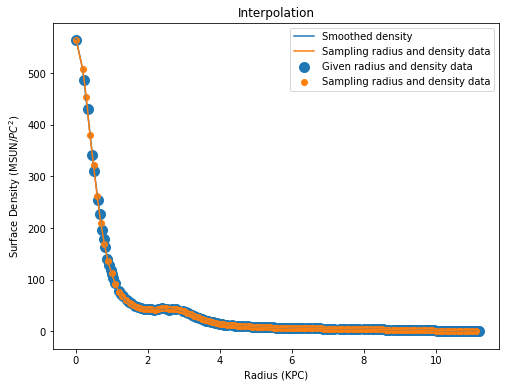

In [10]:
# Just for plotting: evaluate density values at the sampling radii 
density = spline_rhor(radii)
print(density[0])
print(ydinp[0])

# Plot 
plt.figure(figsize=(8,6))
plt.scatter(xdinp,ydinp, label="Given radius and density data", s=100)
plt.scatter(radii,density, label="Sampling radius and density data")
plt.plot(radii,smooth_rhor, label="Smoothed density")
plt.plot(radii,density, label="Sampling radius and density data")
plt.title("Interpolation")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Partial derivative / Smoothing

In [11]:
# Partial derivative of rho(u,z) with respect to u
# Taking the derivative of the splined polynomial (radius and density values, rho(r) or rho(u))
#drho_du = spline_rhor.derivative()
drho_du = spline_smooth_rhor.derivative()

# Evaluating at given radii
drho_du_values = drho_du(radii)

# Smoothing: Savitzky-Golay filter: https://riptutorial.com/scipy/example/15878/using-a-savitzky-golay-filter
drho_du_smooth = savgol_filter(drho_du_values, 11, 3)  # window size 11, polynomial order 5

# Spline the smoothed derivative
spline_drhor = interpd(radii,drho_du_smooth)

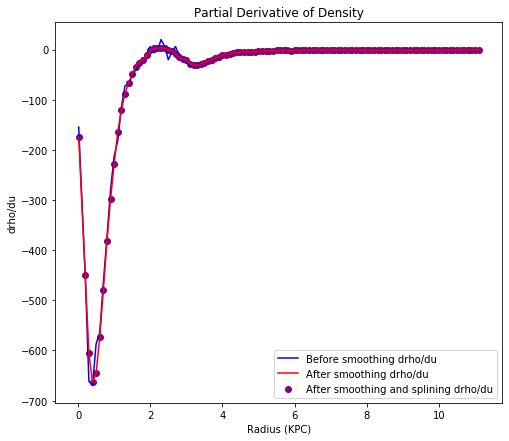

In [12]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du_values, label="Before smoothing drho/du", c="blue")
plt.plot(radii,drho_du_smooth, label="After smoothing drho/du", c="red")
plt.scatter(radii,spline_drhor(radii), label="After smoothing and splining drho/du", c="purple")
plt.title("Partial Derivative of Density")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

## Functions

In [13]:
# Casertano Eq 2
def drho_du(u,z,z0,mode):
    return spline_drhor(u) * denzed(z,z0,mode)

print(drho_du(1,1,z0,mode))

-91.6419095779949


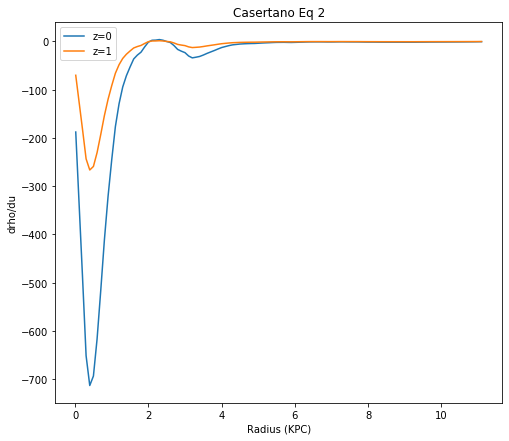

In [14]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,drho_du(radii,0,z0,mode), label="z=0")
plt.plot(radii,drho_du(radii,1,z0,mode), label="z=1")
plt.title("Casertano Eq 2")
plt.xlabel("Radius (KPC)")
plt.ylabel("drho/du")
plt.legend()
plt.show()

In [15]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - (np.sqrt((x**2)-1))

print(px(1,1,1))

0.3819660112501051


In [16]:
# Rotmod elliptic integral and p function (Casertano: Eq A.16)
def func(x,y,z):
    if( x == y ) & ( z == 0):
        r = 0
    elif( x == 0 ) | ( y == 0):
        r = 0
    else:
        xxx = (x*x + y*y + z*z) / (2.0 * x * y)
        rrr = (xxx*xxx - 1.0)
        ppp = 1.0 / (xxx + np.sqrt(rrr))
        fm = 1.0 - ppp*ppp
        el1 = (1.3862944 + fm * (0.1119723 + fm * 0.0725296)) - (0.5 + fm * (0.1213478 + fm * 0.0288729)) * np.log(fm)
        el2 = (1.0 + fm * ( 0.4630151 + fm * 0.1077812 ) ) - (fm * (0.2452727 + fm * 0.0412496)) * np.log(fm)
        r = ((1.0 - xxx * y/x) * el2 / (rrr) + (y/x - ppp) * el1 / np.sqrt(rrr)) / np.pi
        r *= np.sqrt(x / (y * ppp))
    return r

In [17]:
# Complete elliptic integral
def K(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

print(K(1,1,1))

0.35734399698214614


In [18]:
# Integrand, using built-in functions
def integrand(z,r,u,z0,G,mode):
    return ((4 * np.pi * G) * drho_du(u,z,z0,mode) * K(r,u,z) * 2 * np.sqrt(u)) / (np.pi * np.sqrt(r * px(r,u,z)))
    
print(integrand(3,2,1,z0,G,mode))

-1.1972997891376324e-05


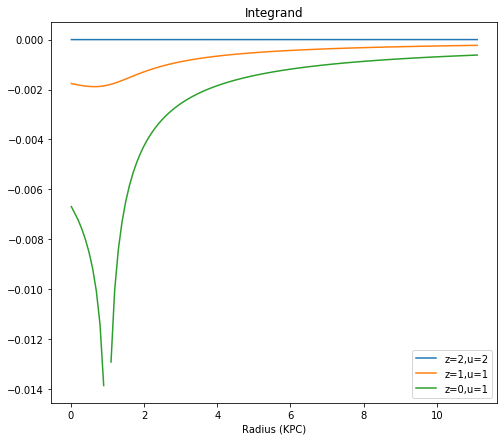

In [19]:
# Plot 
plt.figure(figsize=(8,7))
plt.plot(radii,integrand(2,radii,2,z0,G,mode), label="z=2,u=2")
plt.plot(radii,integrand(1,radii,1,z0,G,mode), label="z=1,u=1")
plt.plot(radii,integrand(0,radii,1,z0,G,mode), label="z=0,u=1")
plt.title("Integrand")
plt.xlabel("Radius (KPC)")
plt.legend()
plt.show()

## Integration

In [20]:
# Define minimum and maximum values of radius for integration
intmin = np.min(radii)
#intmax = np.max(radii)
intmax = np.inf

### Integration, using built-in python functions: scipy quad

In [21]:
# Reverse order of variables to setup for integration
#integrand2 = lambda z,u,r,z0,G,mode: integrand(r,u,z,z0,G,mode)

# Inner integral, integral over z
integrand2 = lambda u,r,z0,G,mode: quad(integrand, intmin, intmax, args=(r,u,z0,G,mode))[0]
print(integrand2(2,1,z0,G,mode))

# Outer integral, integral over u
radialforce = lambda r,z0,G,mode: quad(integrand2, intmin,intmax, args=(r,z0,G,mode))[0]

# Calculate radial force
radialforce = np.vectorize(radialforce)
print(radialforce(1,z0,G,mode))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()


-4.19540585466304e-05


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


134541027412.1368


### Integration, using ROTMOD functions

In [22]:
# Inner integral, integral over z
"""intzed computes the integral over Z that defines the kernel of the integral formula for the rotation velocity. 
This is done for an arbitrary vertical density profile, specified in the function denzed.
The interval of integration is divided into several subintervals, in each of which Simpson's rule is used. 
It is thus possible to have different steps in different regions of the interval of integration, 
and to compute the integral more accurately. An attempt has been made at optimizing the subdivision. 
It is still possible that the kernel is not accurate, especially when R is very close to U. 
It is NOT recommended that the programme is used with very small, but non-zero, values of the thickness. 
On the other hand, the situation with an infinitely thin disk is dealt with properly, the density profile in 
Z being then treated as a Dirac delta function."""
def intzed(r,u,z,z0,mode):
    zeds = np.array([0.02, 0.50, 1.00, 3.00, 10.00])
    
    if (z0 != 0.0):
        n = 10
        
        if (np.abs(r - u) <= (0.2 * z0)):
            n = 200
        
        zne = 0.0
        res = 0.0
        i = 0
        while i < 5: 
            zol = zne
            zne = zeds[i] * z0
            step = (zne - zol) / n
            z = zol
            res += step * func(r,u,z) * drho_du(u,z,z0,mode) / 3.0
            w = 4.0 / 3.0         
            j = 0.0
            while j < n:
                z += step
                res += step * func(r,u,z) * drho_du(u,z,z0,mode) * w
                w = 2.0 - w
                j += 1
            res -= step * func(r,u,z) * drho_du(u,z,z0,mode) / 3.0
            i += 1
    else:
        res = func(r,u,z0)
    return res

# Outer integral, integral over u
def interg(xd,yd,nd,r,rstart,z0,step,ndens,mode):
    vsq = 0.0
    i = 1
    k = 0
    while k < ndens:
        if (k == 0 or k == (ndens - 1)):
            iw = 1
        else:
            iw = 4 - 2 * ((k + 1) % 2)
        
        x = rstart + step * k
        y = 0.0

        if (x < xd[nd-1]): 
            done = False
            while (done == False) & (i < (nd - 1)):
                #if i==1:
                    #print("            Checking xd...") #This if (xd...) loop is entered many times in quick succession; doesn't seem to be hanging so much as running too much. Not seeing the "increased i for the first time" as frequently as I would have expected, but this if statement IS completing quickly.
                if (xd[i-1] <= x) & (xd[i+1] >= x):
                    k1 = i - 1
                    while k1 <= (i + 1):
                        f = 1.0
                        k2 = i - 1
                        while k2 <= (i + 1):
                            if (k1 != k2):
                                f *= (x - xd[k2]) / (xd[k1] - xd[k2])
                            k2 += 1
                        y += f * yd[k1]
                        done = True
                        k1 += 1
                else:
                    i += 1
            if (y > 0.0):
                res = intzed(r,x,y,z0,mode)
                vsq += CONSTANT * res * y * step * iw
        k += 1
    return vsq

In [23]:
velocs_rotmod = np.zeros(len(radii))
nradii = len(radii)
rings = xdinp
nring = len(rings)              # number of sampling radii
ntimes = len(xdinp)             # number of items
ndinp = len(ydinp)
naccur = 10
z1 = 0.58

i = 0
j = 0

while i < nradii:
    r = radii[i]
    vsq = 0.0

    if i == 0:
        print("Loop variables set. Setting variable j...")
    
    while j < nring and rings[j] < r:
        j += 1

    if i == 0:
        print("Initial value of j set to "+str(j)+". Setting additional variables...")
    
    skip = rings[j] != r
    #z1 = z0
    
    r1 = r - 3.0 * z1
    if r1 < 0.0:
        r1 = 0.0
    
    r2 = 0.0
    
    print("r1 = {}".format(r1))
    print("r2 = {}".format(r2))

    if r1 < (rcut + 2.0 * delta):
        r2 = r + (r - r1)
        ndens = 6 * ntimes + 1
        step = (r2 - r1) / (ndens - 1)
        rstart = r1
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,mode)
        
        if r1 > 0.0:
            ndens = r1 * ntimes / h
            ndens = 2 * (ndens / 2) + 3       # multiplies and devides by 2, it's unnecessary
            step = r1 / (ndens - 1)
            rstart = 0.0
            vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,mode)
    
    if r2 < (rcut + 2.0 * delta):
        ndens = (rcut + 2.0 * delta - r2) * ntimes / h
        ndens = 2 * (ndens / 2) + 3
        step = (rcut + 2.0 * delta - r2) / (ndens - 1)
        rstart = r2
        vsq += interg(xdinp,ydinp,ndinp,r,rstart,z0,step,ndens,mode)
    
    print("vsq = {}".format(vsq))
    if vsq < 0.0:
           velocs_rotmod[i] = (-np.sqrt(-vsq))
    else:
           velocs_rotmod[i] = (np.sqrt(vsq))
    i += 1

Loop variables set. Setting variable j...
Initial value of j set to 0. Setting additional variables...
r1 = 0.0
r2 = 0.0
vsq = 0.0002900767614857283
r1 = 0.0
r2 = 0.0
vsq = 0.018398333723552575
r1 = 0.0
r2 = 0.0
vsq = 0.016895546628777267
r1 = 0.0
r2 = 0.0
vsq = 0.010502572522669998
r1 = 0.0
r2 = 0.0
vsq = 0.005659500413500334
r1 = 0.0
r2 = 0.0
vsq = 0.003061470356805653
r1 = 0.0
r2 = 0.0
vsq = 0.0018284030561943807
r1 = 0.0
r2 = 0.0
vsq = 0.0012128922956240594
r1 = 0.0
r2 = 0.0
vsq = 0.0009448853636995978
r1 = 0.0
r2 = 0.0
vsq = 0.0009340470099377031
r1 = 0.0
r2 = 0.0
vsq = 0.0011880975127783577
r1 = 0.0
r2 = 0.0
vsq = 0.001521497886221869
r1 = 0.0
r2 = 0.0
vsq = 0.0018276128039815633
r1 = 0.0
r2 = 0.0
vsq = 0.0019405644354418554
r1 = 0.0
r2 = 0.0
vsq = 0.001762484475684831
r1 = 0.0
r2 = 0.0
vsq = 0.0013694755393469705
r1 = 0.0
r2 = 0.0
vsq = 0.0009317144621116074
r1 = 0.0600000000000005
r2 = 0.0


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


vsq = nan
r1 = 0.16000000000000036
r2 = 0.0
vsq = -0.8162303887188832
r1 = 0.26000000000000023
r2 = 0.0
vsq = nan
r1 = 0.3600000000000003
r2 = 0.0
vsq = nan
r1 = 0.4600000000000004
r2 = 0.0
vsq = -0.46851972070707837
r1 = 0.5600000000000005
r2 = 0.0
vsq = nan
r1 = 0.6600000000000006
r2 = 0.0
vsq = -0.23626844861996904
r1 = 0.7600000000000007
r2 = 0.0
vsq = -0.15684228839446496
r1 = 0.8600000000000003
r2 = 0.0
vsq = -0.10074608520333633
r1 = 0.9600000000000004
r2 = 0.0
vsq = -0.06254260729520862
r1 = 1.0600000000000005
r2 = 0.0
vsq = nan
r1 = 1.1600000000000006
r2 = 0.0
vsq = -0.025637672038826376
r1 = 1.2600000000000007
r2 = 0.0
vsq = nan
r1 = 1.3600000000000003
r2 = 0.0
vsq = nan
r1 = 1.4600000000000004
r2 = 0.0
vsq = -0.017407638587195077
r1 = 1.5600000000000005
r2 = 0.0
vsq = nan
r1 = 1.6600000000000006
r2 = 0.0
vsq = -0.022074142041289897
r1 = 1.7600000000000007
r2 = 0.0
vsq = nan
r1 = 1.8600000000000003
r2 = 0.0
vsq = nan
r1 = 1.9600000000000004
r2 = 0.0
vsq = -0.02682575112949975

### Integration, using built-in python functions: scipy simps

### Integration, using manual simpson's rule

## Velocity

## Comparison

In [24]:
# Gas
tracedgas = np.loadtxt("../NGC_5005/traced_data/ngc5005_gas.txt")
tracedgas_r, tracedgas_v = tracedgas.T
tracedgas_r = tracedgas_r[1:]
tracedgas_v = tracedgas_v[1:]

# Disk
traceddisk = np.loadtxt("../NGC_5005/traced_data/ngc5005_disk.txt")
traceddisk_r, traceddisk_v = traceddisk.T
traceddisk_r = traceddisk_r[1:]
traceddisk_v = traceddisk_v[1:]

## Plot

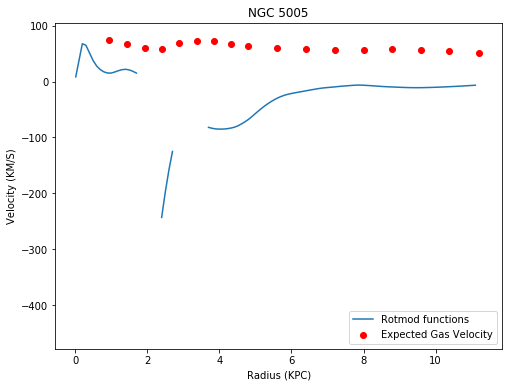

In [25]:
scale = 5e2
plt.figure(figsize=(8,6))             
#plt.scatter(radii, scale*velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, scale*velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii[np.isnan(velocs)==False], scale*velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
#plt.scatter(radii, velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii, velocs, linestyle='solid', label='Scaled calculated gas velocity by {}'.format(scale))
#plt.plot(radii[np.isnan(velocs)==False], velocs_smooth, linestyle='solid', label='Smoothed Gas Velocity')
plt.plot(radii, scale*velocs_rotmod, linestyle='solid', label='Rotmod functions')
#plt.plot(radii, scale*velocs_simps, linestyle='solid', label='Scipy Simpson rule')
plt.scatter(tracedgas_r, tracedgas_v, label='Expected Gas Velocity', c='red')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=10)
plt.ylabel('Velocity (KM/S)', fontsize=10)
#plt.xlim(0,12)
plt.legend(fontsize=10)
plt.show()

In [26]:
print(radii)
print(velocs)

[ 0.0172  0.2     0.3     0.4     0.5     0.6     0.7     0.8     0.9
  1.      1.1     1.2     1.3     1.4     1.5     1.6     1.7     1.8
  1.9     2.      2.1     2.2     2.3     2.4     2.5     2.6     2.7
  2.8     2.9     3.      3.1     3.2     3.3     3.4     3.5     3.6
  3.7     3.8     3.9     4.      4.1     4.2     4.3     4.4     4.5
  4.6     4.7     4.8     4.9     5.      5.1     5.2     5.3     5.4
  5.5     5.6     5.7     5.8     5.9     6.      6.1     6.2     6.3
  6.4     6.5     6.6     6.7     6.8     6.9     7.      7.1     7.2
  7.3     7.4     7.5     7.6     7.7     7.8     7.9     8.      8.1
  8.2     8.3     8.4     8.5     8.6     8.7     8.8     8.9     9.
  9.1     9.2     9.3     9.4     9.5     9.6     9.7     9.8     9.9
 10.     10.1    10.2    10.3    10.4    10.5    10.6    10.7    10.8
 10.9    11.     11.1   ]


NameError: name 'velocs' is not defined